In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from scipy.optimize import least_squares as ls
from rbergomi import rBergomi

In [2]:
S0 = 4017.8
t0 = "23 Jan 2023"

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100

rB_iv = np.array(pd.read_csv("rB_iv.csv"))
rB_param = np.array(pd.read_csv("rB_parameters.csv"))

In [3]:
def price_call(S, K, N, r, q, T):
    N = len(K)
    p = np.zeros(N)
    for i in range(N):
        p[i] = np.mean(np.maximum(S[:,-1]-K[i],0)*np.exp(-(r-q)*T))
    return p

In [4]:
start_time_all = time.time()
nr = len(maturities); rB_skew = np.zeros(nr);
N = 25000; n = 1500;
t = np.zeros(nr)
h = 1e-3; K_skew = np.array([S0*(1+h), S0*(1-h)]);

for i in range(nr):
    
    start_time = time.time()
    
    vol = IV[i]; T = maturities[i];
    
    if T > 0.5:
        N = 20000; n = 1000;
    if T > 1:
        N = 20000; n = 300;
    if T > 3:
        N = 15000; n = 100;
    
    r = iD.implied_drift(T); q = 0;
    
    def rb(x):
    
        np.random.seed(0)

        H, eta, rho = x
        alpha = H - 0.5

        rB = rBergomi(n, N, T, alpha)
        
        xi = vc.variance_curve(rB.t[0])
        
        dW1 = rB.dW1(); dW2 = rB.dW2();
        Ya = rB.Y(dW1)
        dZ = rB.dZ(dW1, dW2, rho)
        V = rB.V(Ya, xi, eta)
        S = rB.S(V, dZ, r, q, S0)

        P = price_call(S, K_skew, N, r, q, T)
        
        rB_v = bs.BSImpliedVol(S0, K_skew, T, r, q, P, Option_type = 1, toll = 1e-10)

        return rB_v
    
    rB_skew[i] = np.abs(np.diff(rb(rB_param[i,:])))/(2*h)
    
    t[i] = time.time() - start_time

    print(f'Iteration: {i}\t Elapsed time: {t[i]: .0f} s')

total_time = (time.time() - start_time_all)/60

print(f'Total execution time: {total_time: .0f} minutes')

Iteration: 0	 Elapsed time:  1 s
Iteration: 1	 Elapsed time:  1 s
Iteration: 2	 Elapsed time:  2 s
Iteration: 3	 Elapsed time:  2 s
Iteration: 4	 Elapsed time:  4 s
Iteration: 5	 Elapsed time:  11 s
Iteration: 6	 Elapsed time:  8 s
Iteration: 7	 Elapsed time:  8 s
Iteration: 8	 Elapsed time:  10 s
Iteration: 9	 Elapsed time:  12 s
Iteration: 10	 Elapsed time:  12 s
Iteration: 11	 Elapsed time:  5 s
Iteration: 12	 Elapsed time:  5 s
Iteration: 13	 Elapsed time:  6 s
Iteration: 14	 Elapsed time:  6 s
Iteration: 15	 Elapsed time:  9 s
Iteration: 16	 Elapsed time:  10 s
Iteration: 17	 Elapsed time:  9 s
Iteration: 18	 Elapsed time:  10 s
Iteration: 19	 Elapsed time:  2 s
Iteration: 20	 Elapsed time:  2 s
Iteration: 21	 Elapsed time:  3 s
Iteration: 22	 Elapsed time:  4 s
Iteration: 23	 Elapsed time:  8 s
Iteration: 24	 Elapsed time:  2 s
Iteration: 25	 Elapsed time:  3 s
Iteration: 26	 Elapsed time:  3 s
Iteration: 27	 Elapsed time:  4 s
Iteration: 28	 Elapsed time:  4 s
Iteration: 29	 Ela

<IPython.core.display.Javascript object>


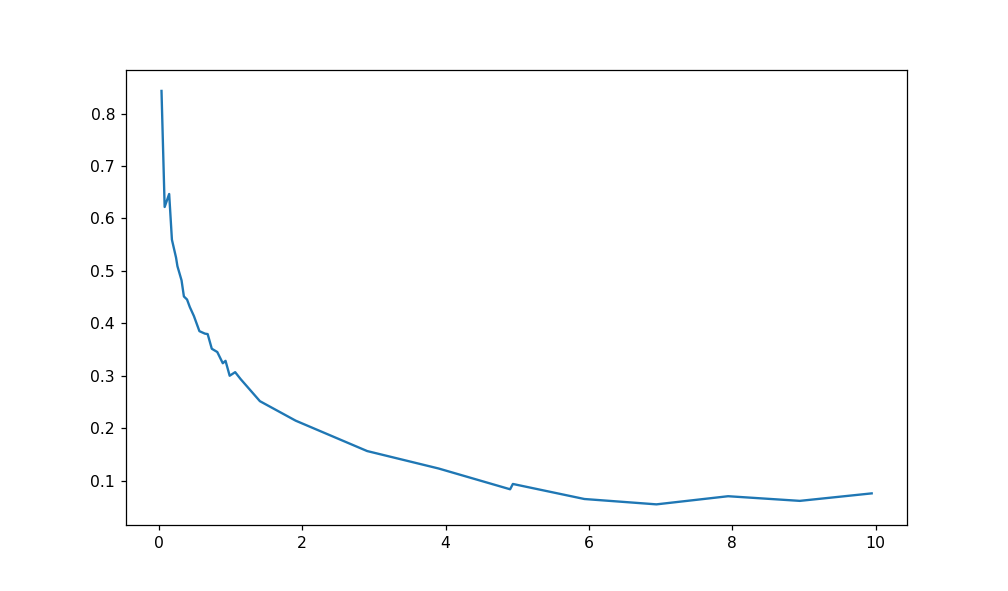

In [5]:
%matplotlib notebook

plt.plot(maturities, rB_skew)

In [6]:
start_time_all = time.time()

svi_param = np.zeros([nr,5])

log_moneyness = np.log(moneyness/100)

inp = np.array([3, 1, 0.5, 1, 0.5])
bnds = ([-np.inf, 0, -0.999, -np.inf, 0.00001], [np.inf, np.inf, 0.999, np.inf, np.inf])

for i in range(nr):
    
    def g(x,k):
        a,b,rho,m,sigma = x
        return a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2))
    
    def f(x):
        a,b,rho,m,sigma = x
        return g(x, log_moneyness) - IV[i,:]**2
    
    result = ls(f, inp, bounds = bnds, max_nfev = 100, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
    
    svi_param[i,:] = result.x

total_time = (time.time() - start_time_all)

print(f'Total execution time: {total_time: .2f} s')

Total execution time:  1.33 s


<IPython.core.display.Javascript object>


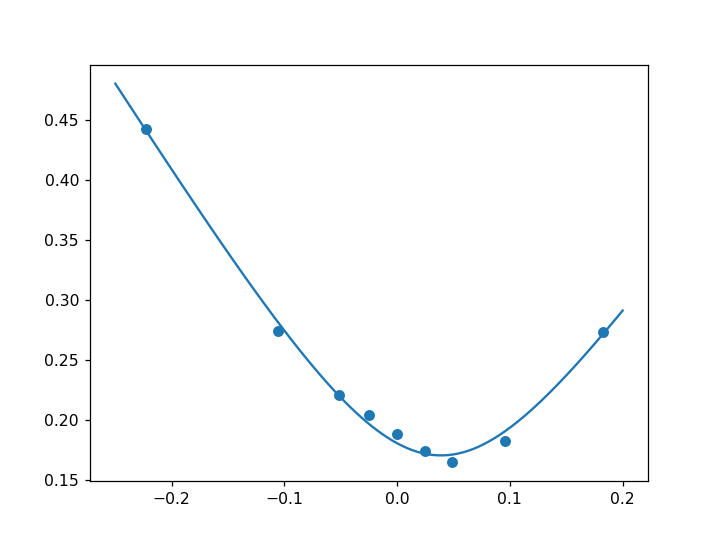

<IPython.core.display.Javascript object>


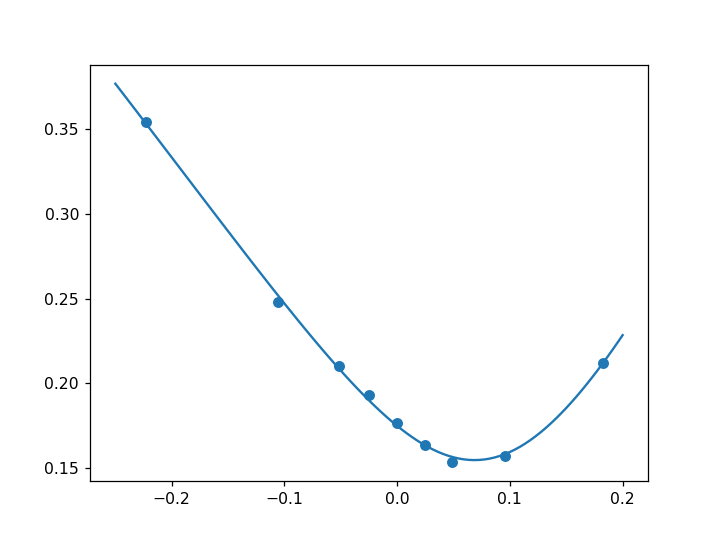

<IPython.core.display.Javascript object>


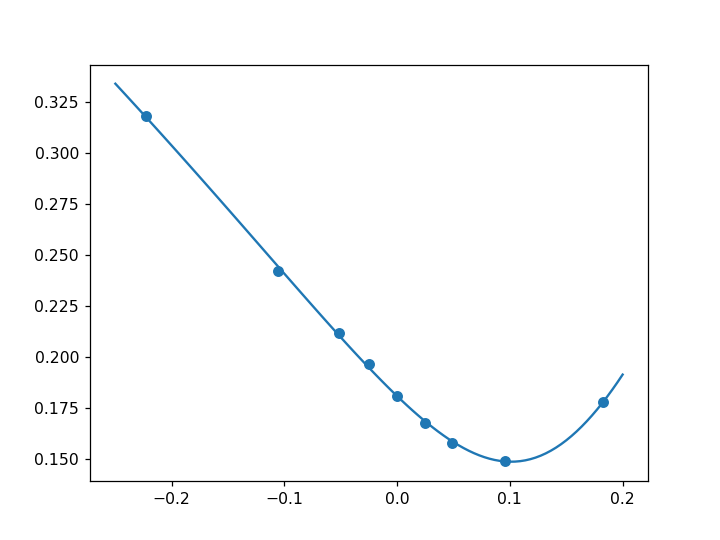

<IPython.core.display.Javascript object>


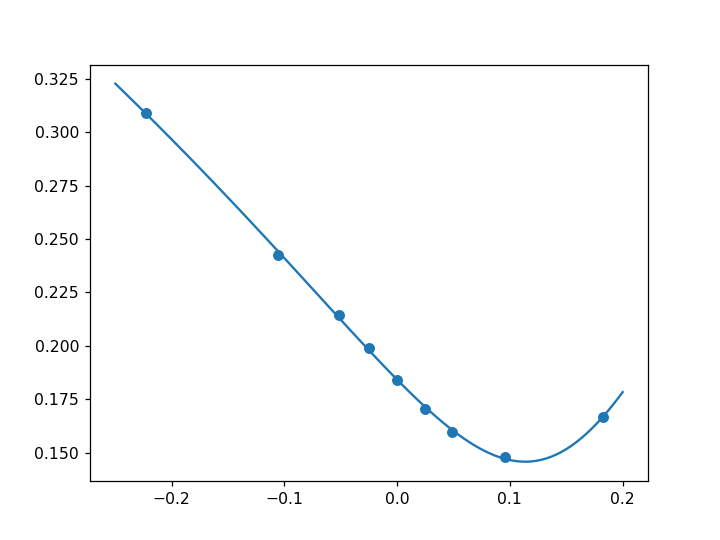

<IPython.core.display.Javascript object>


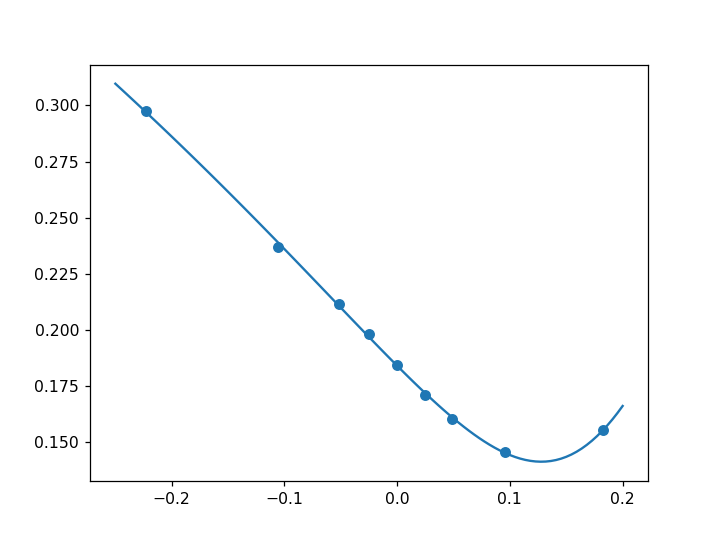

<IPython.core.display.Javascript object>


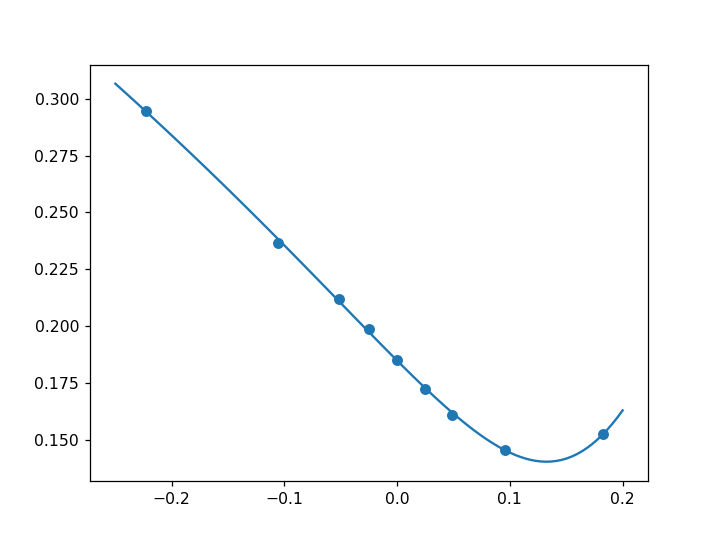

<IPython.core.display.Javascript object>


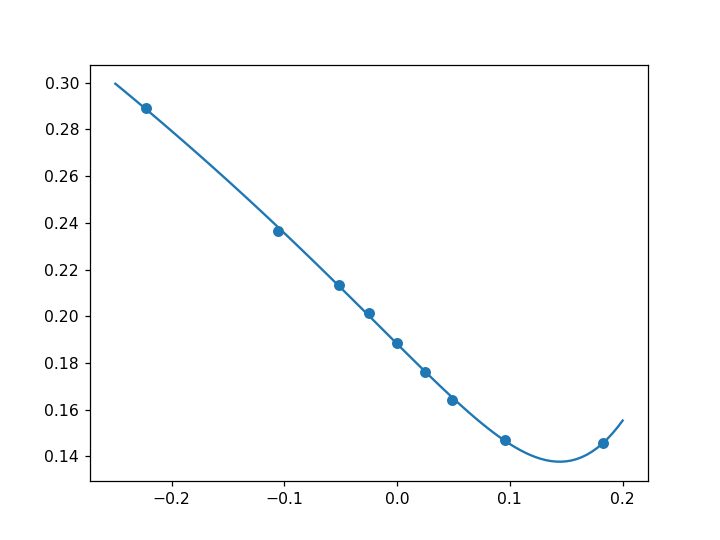

<IPython.core.display.Javascript object>


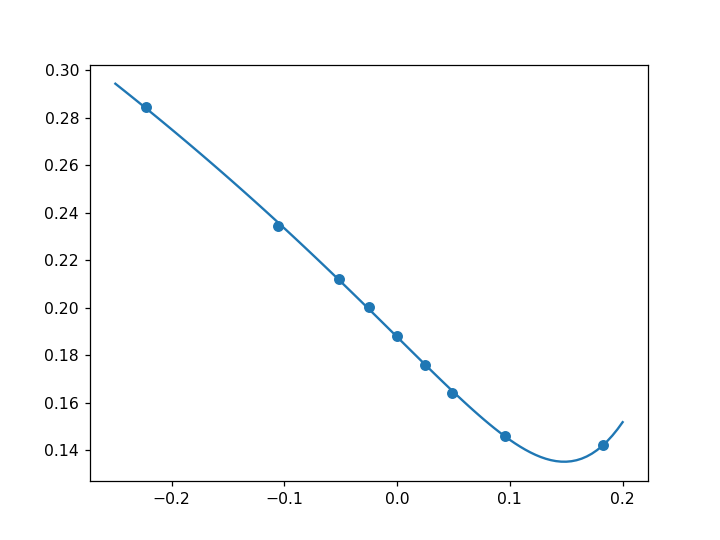

<IPython.core.display.Javascript object>


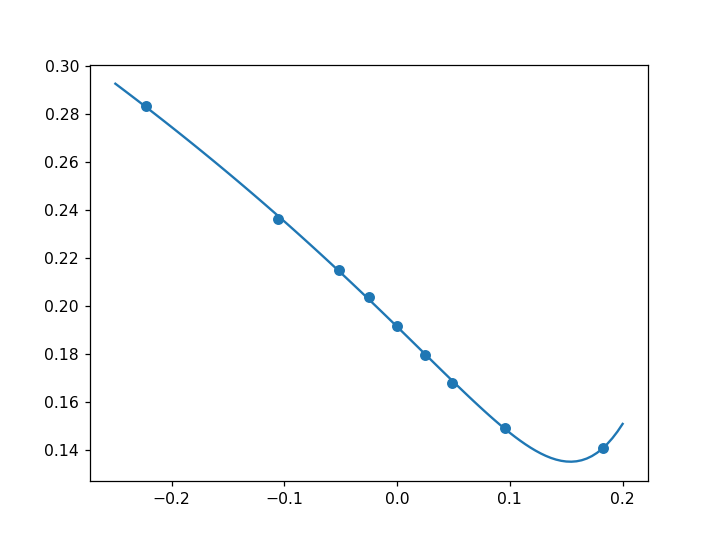

<IPython.core.display.Javascript object>


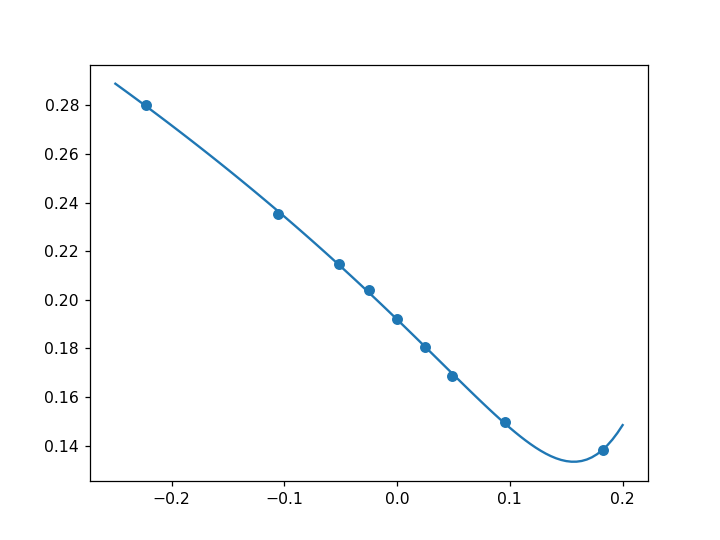

<IPython.core.display.Javascript object>


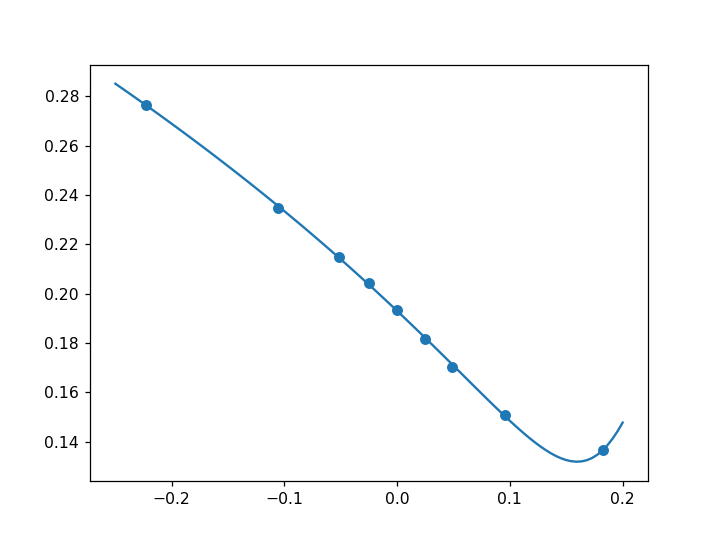

<IPython.core.display.Javascript object>


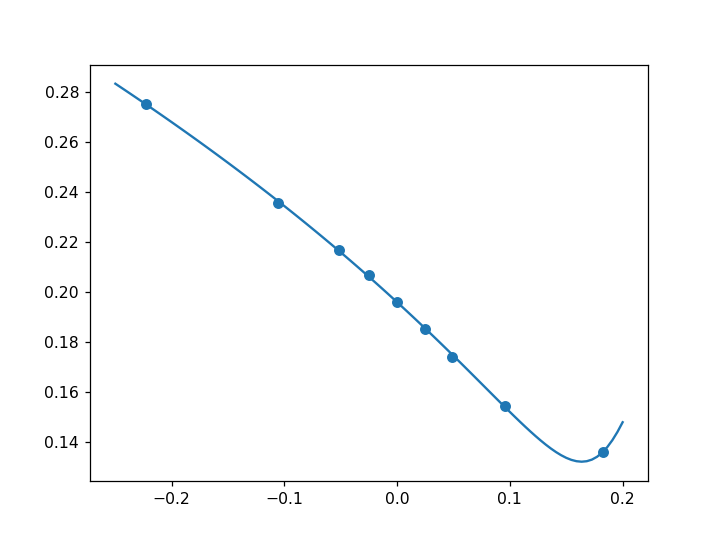

<IPython.core.display.Javascript object>


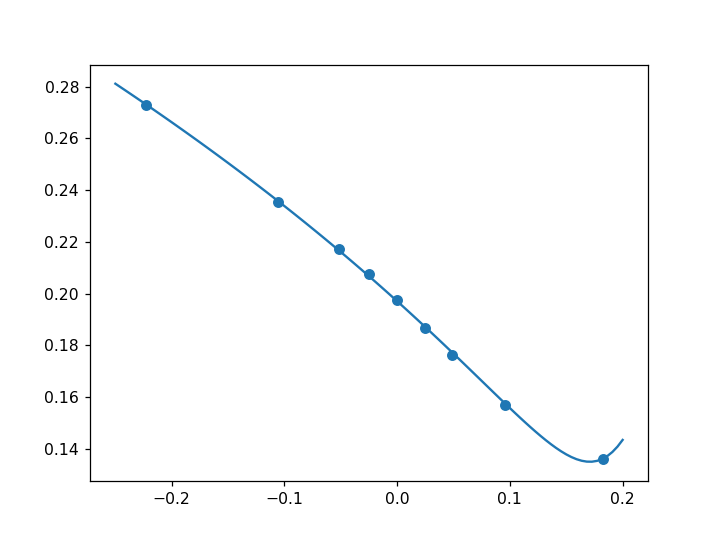

<IPython.core.display.Javascript object>


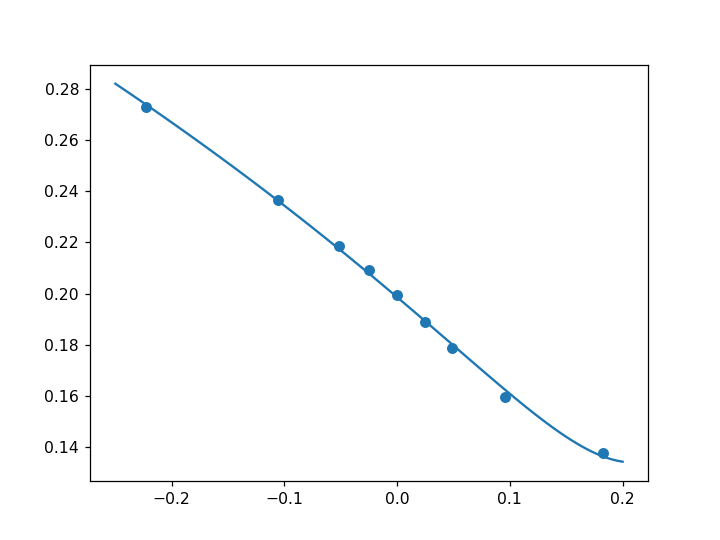

<IPython.core.display.Javascript object>


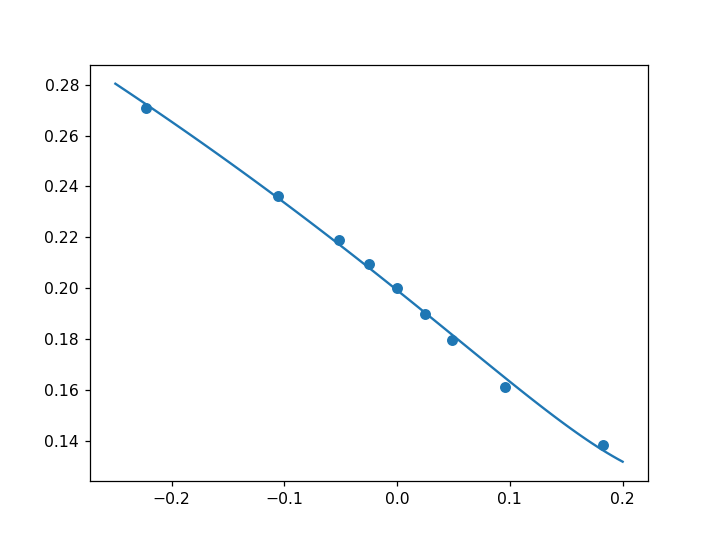

<IPython.core.display.Javascript object>


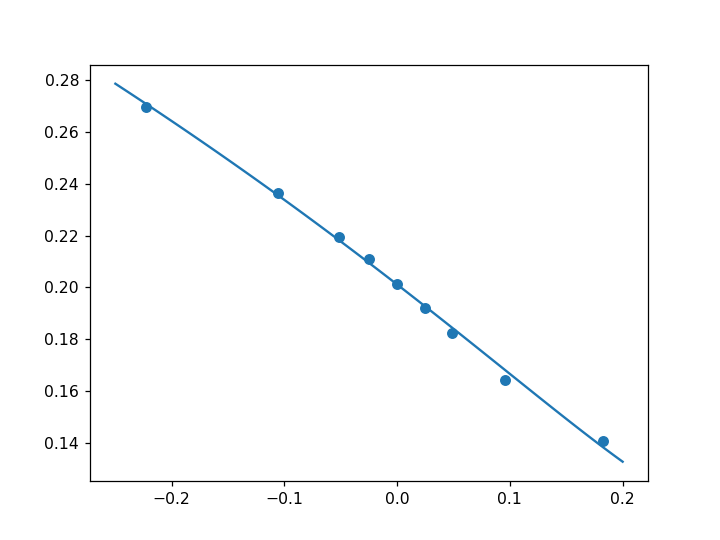

<IPython.core.display.Javascript object>


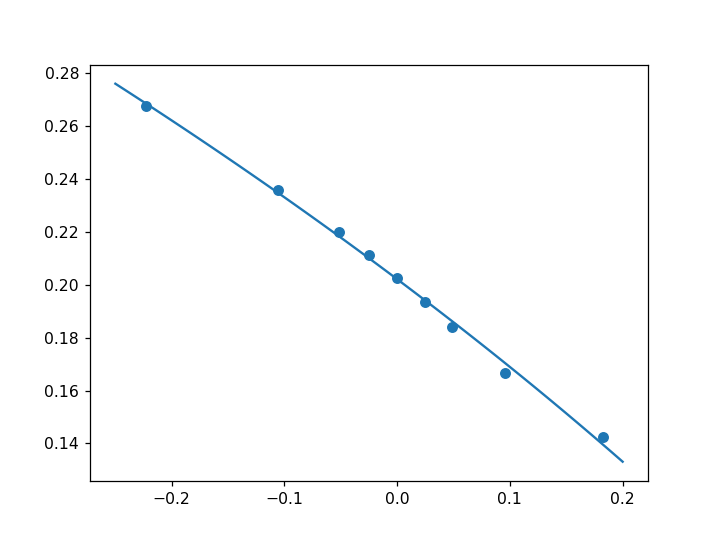

<IPython.core.display.Javascript object>


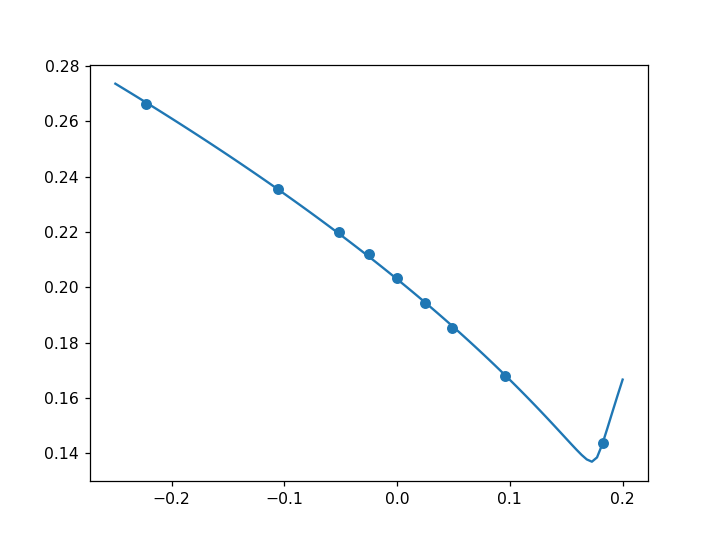

<IPython.core.display.Javascript object>


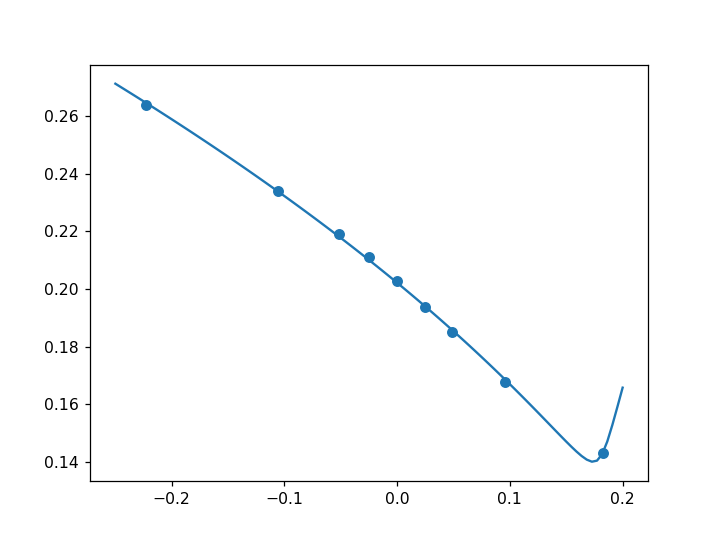

<IPython.core.display.Javascript object>


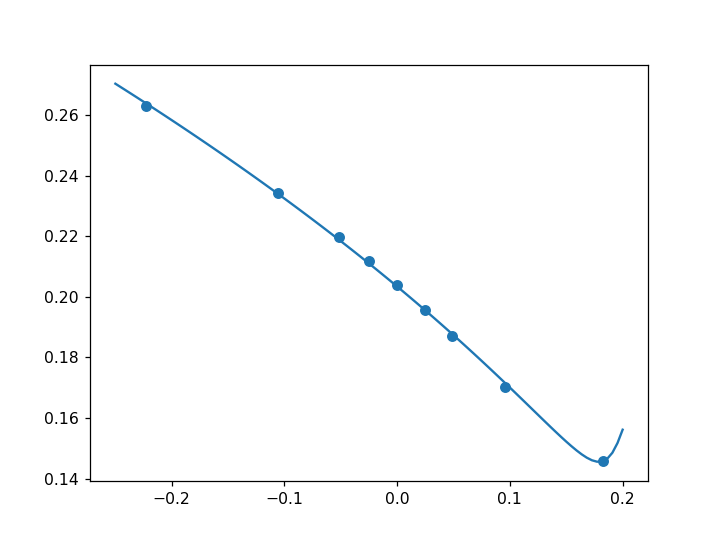

C:\Users\super\AppData\Local\Temp\ipykernel_304\1844409077.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


<IPython.core.display.Javascript object>


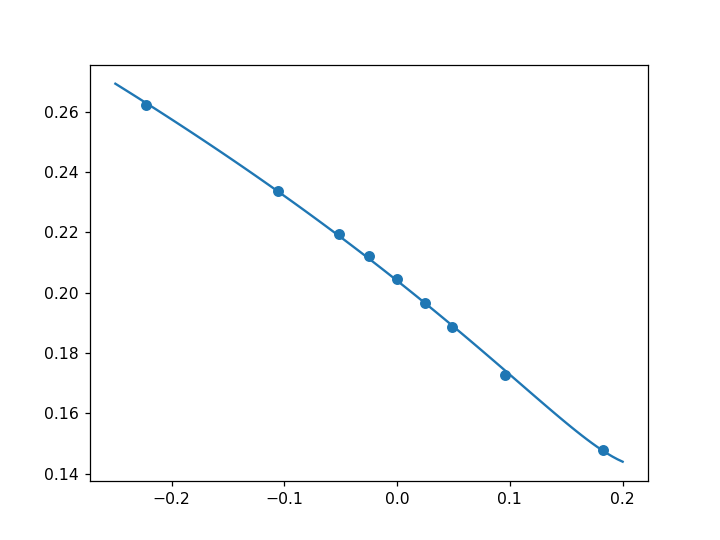

<IPython.core.display.Javascript object>


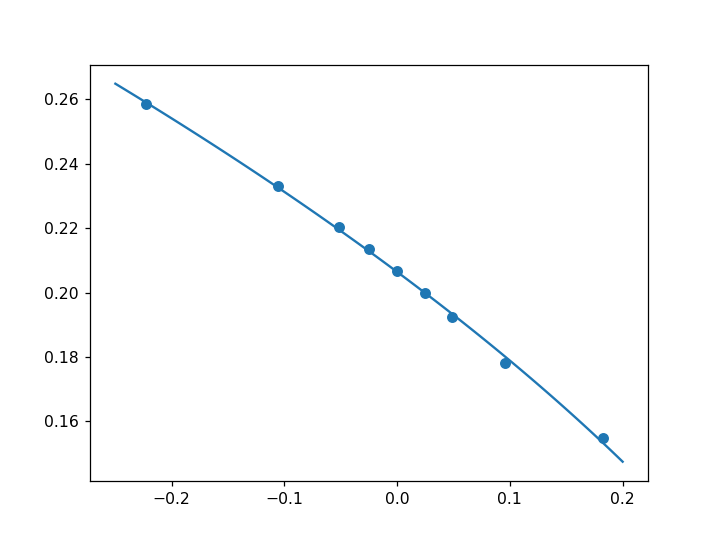

<IPython.core.display.Javascript object>


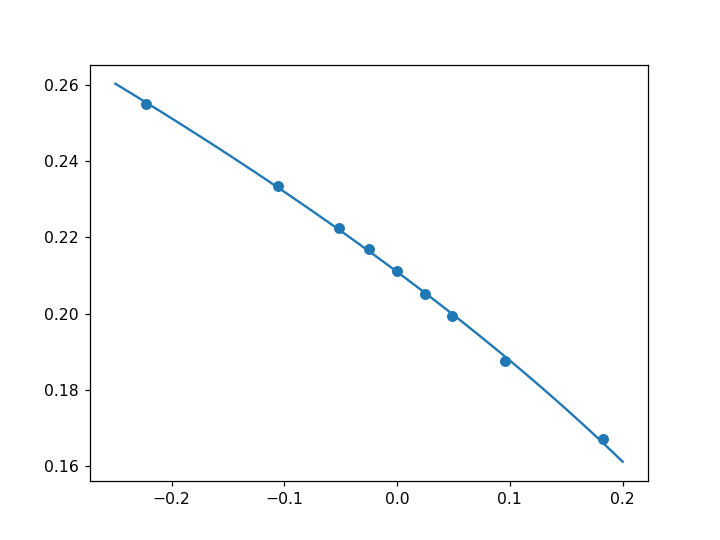

<IPython.core.display.Javascript object>


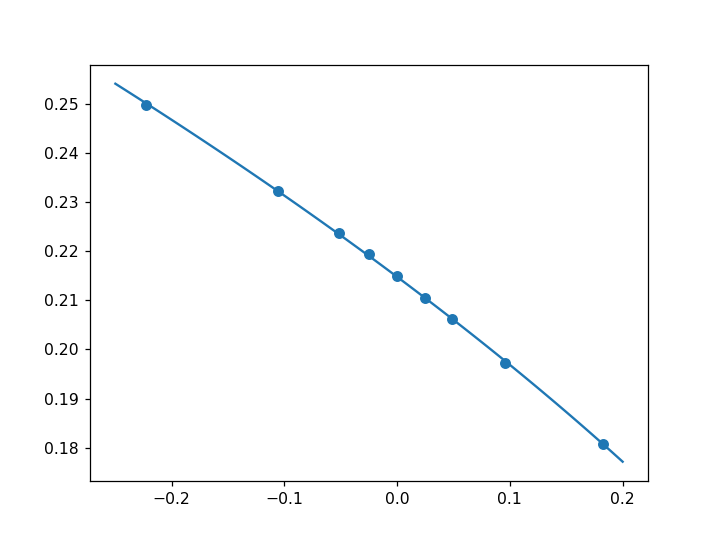

<IPython.core.display.Javascript object>


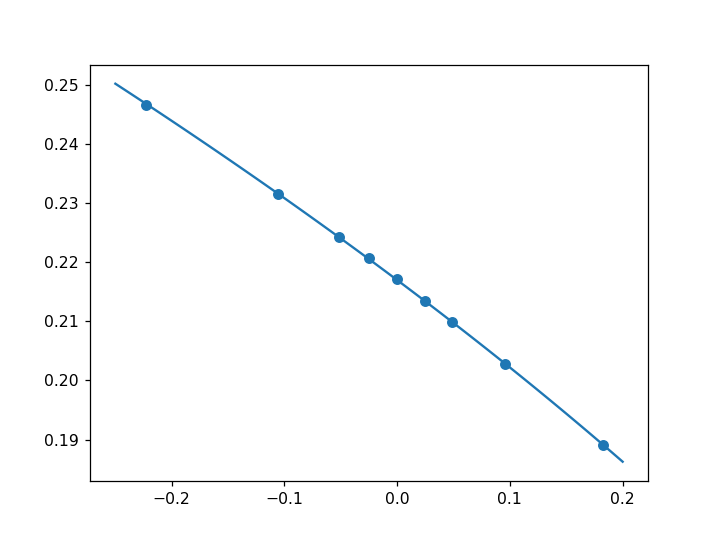

<IPython.core.display.Javascript object>


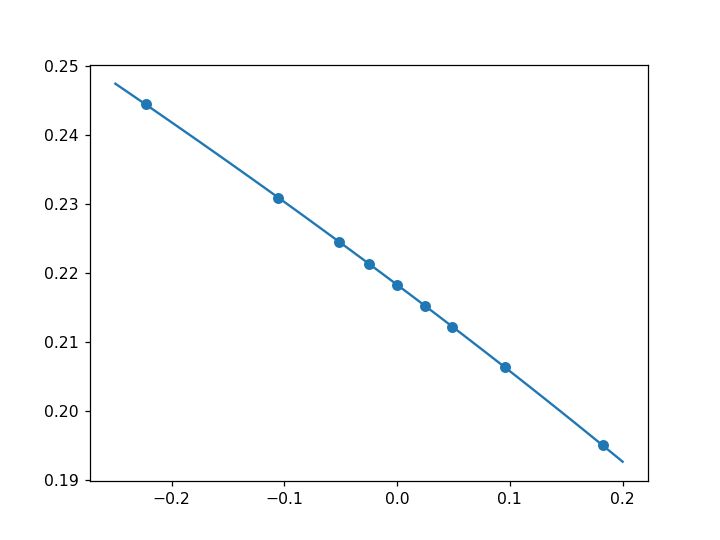

<IPython.core.display.Javascript object>


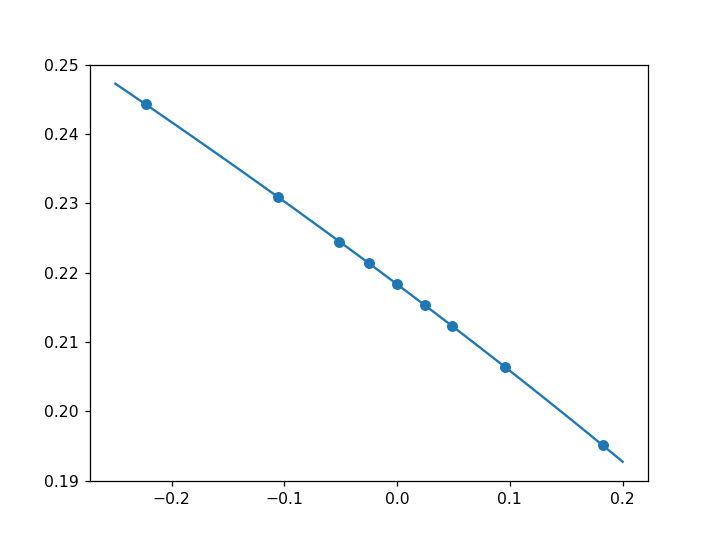

<IPython.core.display.Javascript object>


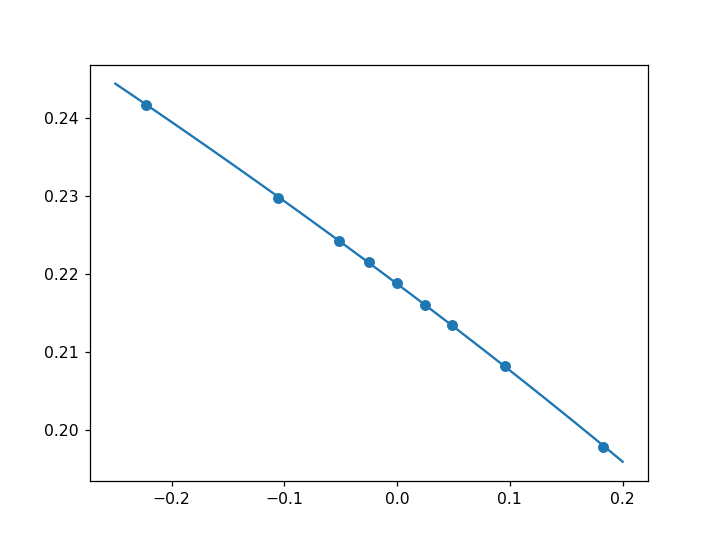

<IPython.core.display.Javascript object>


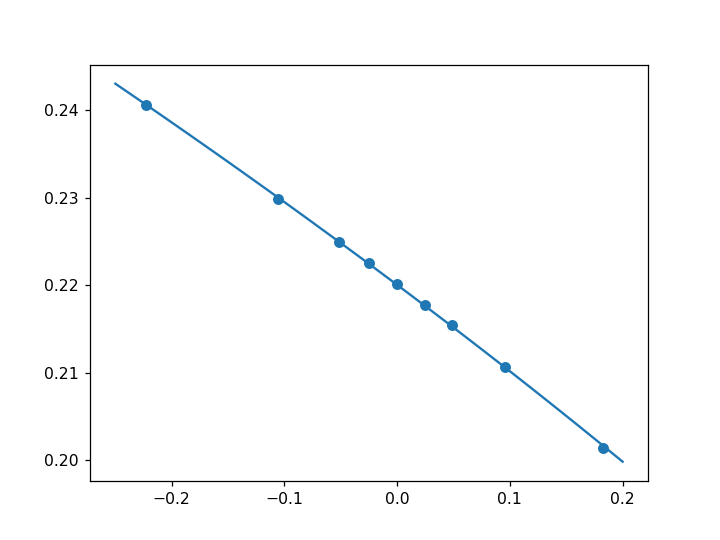

<IPython.core.display.Javascript object>


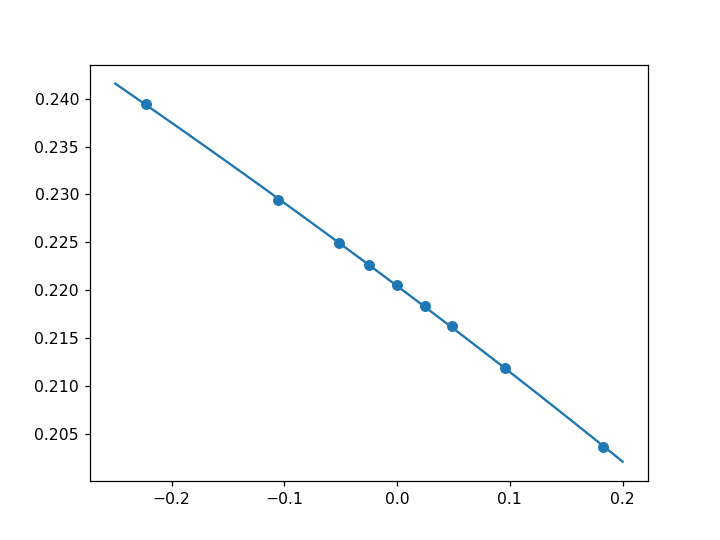

<IPython.core.display.Javascript object>


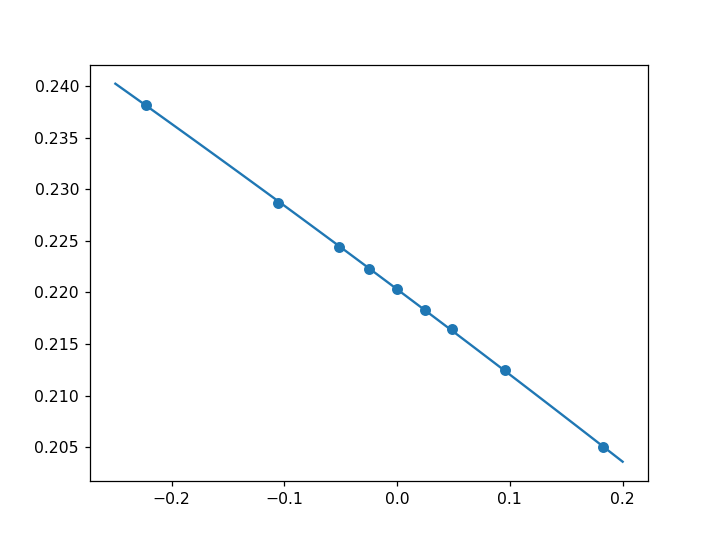

<IPython.core.display.Javascript object>


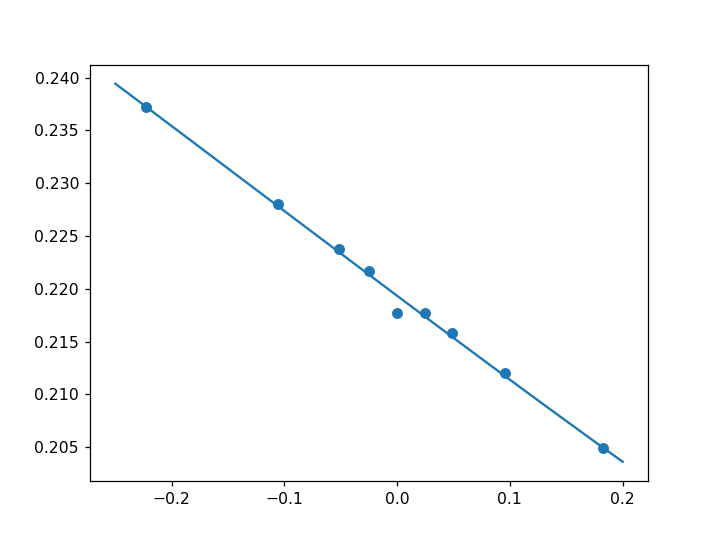

In [7]:
%matplotlib notebook

points = np.linspace(-.25, .2, 100)

for i in range(nr):
    plt.figure(i)
    plt.plot(points, np.sqrt(g(svi_param[i,:], points)))
    plt.scatter(log_moneyness, IV[i,:])

In [8]:
for i in range(nr):
    a,b,rho,m,sigma = svi_param[i,:]
    if a+b*sigma*np.sqrt(1-rho**2) < 0:
        print("Failed condition on:",i)

Failed condition on: 16
Failed condition on: 21
Failed condition on: 22
Failed condition on: 23
Failed condition on: 24
Failed condition on: 25
Failed condition on: 26
Failed condition on: 27
Failed condition on: 28
Failed condition on: 29


In [14]:
market_skew = np.zeros(nr)
k = 0

def f(x):
    a,b,rho,m,sigma = x
    return np.sqrt(a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2)))

for i in range(nr):
    
    def g(x):
        a,b,rho,m,sigma = x
        return b * ((k-m)/np.sqrt((k-m)**2+sigma**2)+rho) / (2*f(x))
    
    market_skew[i] = np.abs(g(svi_param[i,:]))

<IPython.core.display.Javascript object>


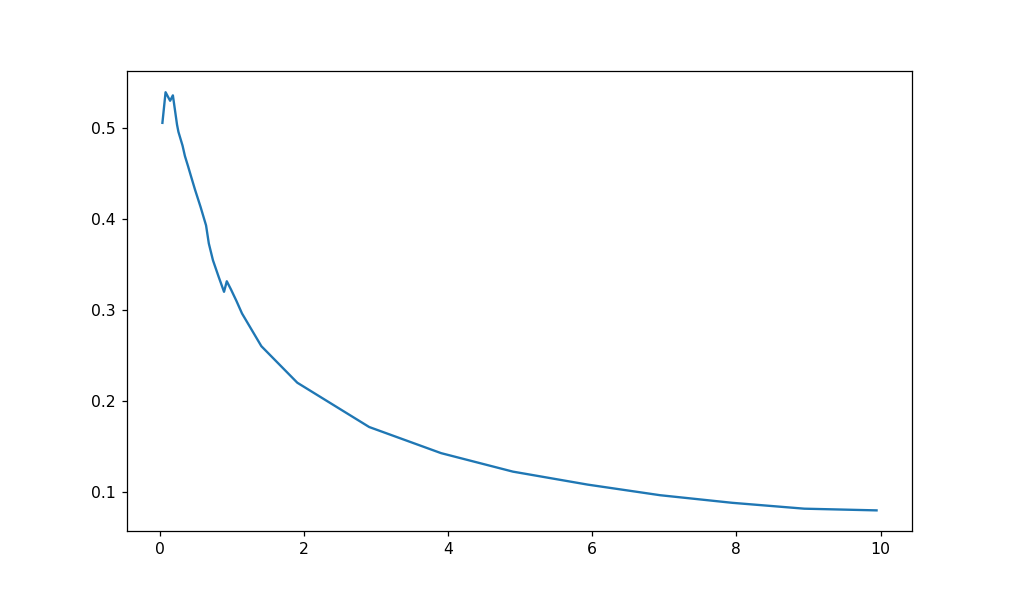

In [15]:
%matplotlib notebook

plt.plot(maturities, market_skew)

<IPython.core.display.Javascript object>


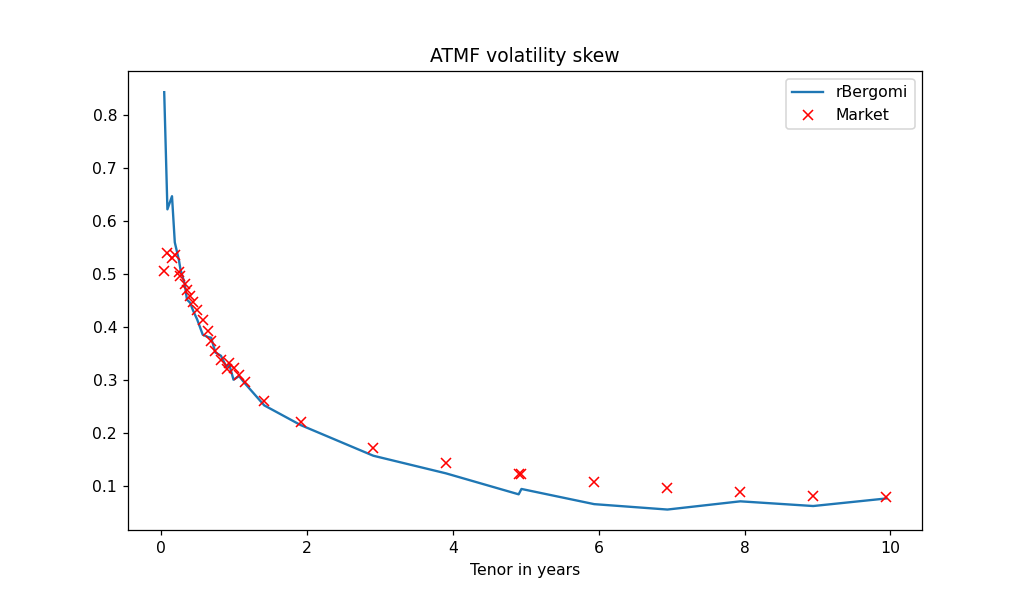

Text(0.5, 0, 'Tenor in years')

In [11]:
%matplotlib notebook

plt.plot(maturities, rB_skew)
plt.plot(maturities, market_skew, 'rx')
plt.legend(["rBergomi", "Market"])
plt.title("ATMF volatility skew")
plt.xlabel("Tenor in years")

In [16]:
for i in range(nr):
    
    def g(x, tau):
        A,alpha = x
        return A * tau**(-alpha)
    
    def f(x):
        return g(x, maturities) - market_skew
    
    result = ls(f, np.ones(2), max_nfev = 100, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
    
    power_law_param = result.x

<IPython.core.display.Javascript object>


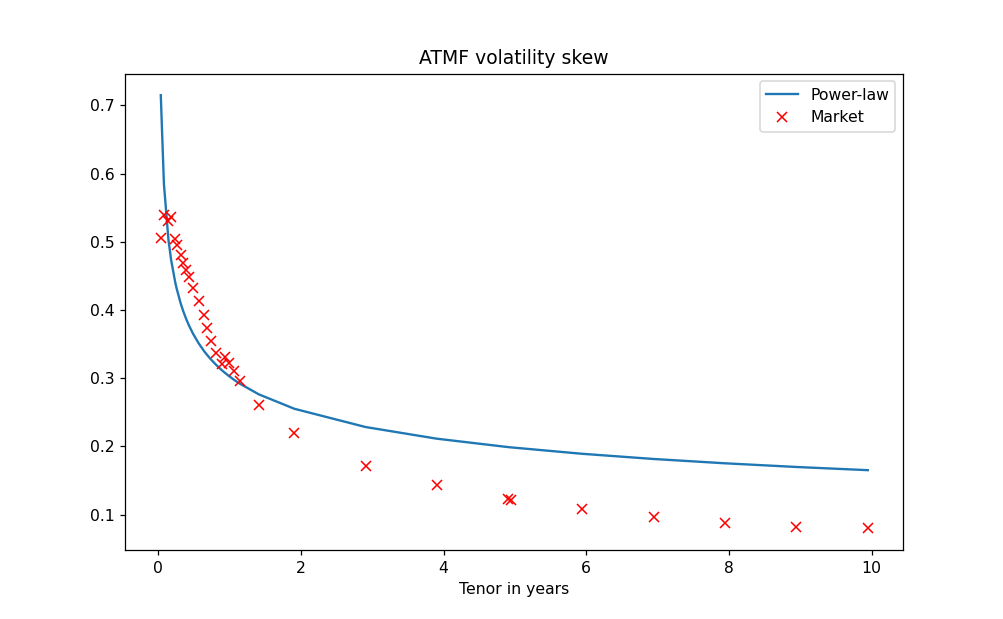

Text(0.5, 0, 'Tenor in years')

In [17]:
%matplotlib notebook

def g(x):
    A,alpha = x
    return A * maturities**(-alpha)

plt.plot(maturities, g(power_law_param))
plt.plot(maturities, market_skew, 'rx')
plt.legend(["Power-law", "Market"])
plt.title("ATMF volatility skew")
plt.xlabel("Tenor in years")

In [18]:
power_law_param

array([0.30263661, 0.26363489])